## Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import os
import copy
from keras.layers import Input, Concatenate, Dense, GlobalMaxPooling1D, Reshape, Multiply, dot, Conv1D, MaxPool1D, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten, Embedding, Activation
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer

# Creating dummy data

### Example: 
They performed
Kashmir,
written by
Page
and Plant.
Page played
unusual chords
on his Gibson.

#### Graph can be downloaded from https://github.com/codepie/aida github repository from class: mpi.aida.graph.GraphGenerator -> function run()

In [ ]:
mentions = ['kashmir', 'page', 'plant', 'gibson']
entities_raw = [['Kashmir (song)', 'Kashmir'], ['Larry Page', 'Jimmy Page', 'Page, Arizona'], ['Robert Plant'], ['Gibson Les Paul', 'Gibson, Arkansas']]

In [ ]:
# Count number of mentions identified in the text document
num_mention = len(mentions)
num_entities = 5 * num_mention  # restricting number of candidate entities to be maximum of 5 for each mentions

In [ ]:
entities = copy.deepcopy(entities_raw)
#Updating entities to have 'na' if number of candidate entities is less than 5
for en_list in entities:
    while(len(en_list) < 5):
      en_list.append('na')

print(entities_raw)
print(entities)

[['Kashmir (song)', 'Kashmir'], ['Larry Page', 'Jimmy Page', 'Page, Arizona'], ['Robert Plant'], ['Gibson Les Paul', 'Gibson, Arkansas']]
[['Kashmir (song)', 'Kashmir', 'na', 'na', 'na'], ['Larry Page', 'Jimmy Page', 'Page, Arizona', 'na', 'na'], ['Robert Plant', 'na', 'na', 'na', 'na'], ['Gibson Les Paul', 'Gibson, Arkansas', 'na', 'na', 'na']]


In [ ]:
adj_me = np.zeros((num_mention,num_entities))
adj_ee = np.zeros((num_entities,num_entities))

In [ ]:
adj_me[0,0] = 1
adj_me[0,1] = 1
adj_me[1,5] = 1
adj_me[1,6] = 1
adj_me[1,7] = 1
adj_me[2,10] = 1
adj_me[3,15] = 1
adj_me[3,16] = 1

In [ ]:
adj_ee[0,6] = 1
adj_ee[0,10] = 1
adj_ee[1,7] = 1
adj_ee[6,10] = 1
adj_ee[6,15] = 1
adj_ee[7,16] = 1

In [ ]:
adj_mention_entity = np.stack((adj_me, adj_me))   #stacking adjacency matrices together to represent 2 unique records
adj_entity_entity = np.stack((adj_ee, adj_ee))    #stacking adjacency matrices together to represent 2 unique records

In [ ]:
#Save adjacency matrices as npy files
np.save('adj_mention_entity.npy', adj_mention_entity)
np.save('adj_entity_entity.npy', adj_entity_entity)

### Wikipedia2Vec embedding

In [ ]:
# upload pretrained embedding binary file

In [ ]:
# get wikipedia2vec API
pip install wikipedia2vec
from wikipedia2vec import Wikipedia2Vec
wiki2vec = Wikipedia2Vec.load('/path/to/pretrained/model')

In [ ]:
# get vector embedding for mentions
mentions = ['mentions list']
def get_mention_embeddings(mentions):
    d = {}
    for mention in mentions:
        vector = wiki2vec.get_word_vector(mention)
        d[mention] = vector
    df = pd.DataFrame(d)
    df = df.T
    df.to_csv('mentions.csv')
get_mention_embeddings(mentions)

In [ ]:
# get vector embedding for entities
entities = ['entites list']
def get_entity_embeddings(entities):
    d = {}
    for mention in mentions:
        vector = wiki2vec.get_entity_vector(mention)
        d[mention] = vector
    df = pd.DataFrame(d)
    df = df.T
    df.to_csv('entities_embedding.csv')
get_entity_embeddings(entities)

In [ ]:
emb_mentions = pd.read_csv('/content/mentions_embedding.csv')
emb_entities = pd.read_csv('/content/entities_embedding.csv')

## Transforming Embedding CSV to Matrix for all mentions to be without the mention name

In [ ]:
mention_embedding_matrix = np.zeros((num_mention, 100))
for i, mention in enumerate(mentions):
  if mention in emb_mentions['Unnamed: 0'].tolist():
    index = emb_mentions.index[emb_mentions['Unnamed: 0']==mention]
    arr = emb_mentions.iloc[index.values[0]][1:].to_numpy()
    arr_reshaped = np.reshape(arr, (1,100))
    mention_embedding_matrix[i,:] = arr


## Transforming Entities Embedding CSV to Matrix for 5 entities per mention to be without the entities name

In [ ]:
entities_embedding_matrix = np.zeros((num_entities, 100))
embedding_entities_list = emb_entities['Unnamed: 0'].tolist()
i = 0
for entity_list in entities:
  for entity in entity_list:
    if entity in embedding_entities_list:
      index = emb_entities.index[emb_entities['Unnamed: 0']==entity]
      arr = emb_entities.iloc[index.values[0]][1:].to_numpy()
      arr_reshaped = np.reshape(arr, (1,100))
      entities_embedding_matrix[i,:] = arr
    i+=1

# Build Input for CNN Model

In [ ]:
input1 = tf.zeros([100, 100])
input2 = tf.zeros([100, 100])

for rec in range(len(adj_mention_entity)):
  # mention_embedding * adjacency_mention_entity * entities_embedding
  input1 = tf.matmul(tf.matmul(mention_embedding_matrix.T, adj_mention_entity[rec]), entities_embedding_matrix)
  # entities_embedding * adjacency_entity_entity * entities_embedding
  input2 = tf.matmul(tf.matmul(entities_embedding_matrix.T, adj_entity_entity[rec]), entities_embedding_matrix)

input1 = tf.reshape(input1, (1,100,100))
input2 = tf.reshape(input2, (1,100,100))


multiple = tf.constant([num_mention, 1, 1], tf.int32)

# stack same input1 for num_mention number of mentions. This is because for same input1 & input2 are required for all individual mention training
cnn_input1 = tf.tile(input1, multiple)
cnn_input2 = tf.tile(input2, multiple)

In [ ]:
mention_inputs = tf.convert_to_tensor(mention_embedding_matrix)
mention_entities = np.split(entities_embedding_matrix, num_mention)
entities_inputs = np.empty((4,500))
for i in range(num_mention):
  entities_inputs[i] = np.reshape(mention_entities[i].flatten(), (1,500))

entities_inputs = tf.convert_to_tensor(entities_inputs2)

### Dummy y for holding true value index one-hot for all input mentions

In [ ]:
result1 = tf.reshape(tf.constant([1.0, 0.0, 0.0, 0.0, 0.0]), (1,5)) # for mention Kashmir
result2 = tf.reshape(tf.constant([0.0, 1.0, 0.0, 0.0, 0.0]), (1,5)) # for mention Page
result3 = tf.reshape(tf.constant([1.0, 0.0, 0.0, 0.0, 0.0]), (1,5)) # for mention Plant
result4 = tf.reshape(tf.constant([1.0, 0.0, 0.0, 0.0, 0.0]), (1,5)) # for mention Gibson


result = np.empty((num_mention,5))
result[0] = result1
result[1] = result2
result[2] = result3
result[3] = result4

result = tf.convert_to_tensor(result)

## CNN Model Architecture

In [ ]:
model_input1 = Input(shape=(100, 100), name='input1')
model_input2 = Input(shape=(100, 100), name='input2')
mention_x = Input(shape=(100), name='mention_input')
entities_x = Input(shape=(500), name = 'entities_input')

model_input = Concatenate(axis=1) ([model_input1, model_input2])

x = Conv1D(filters=100, kernel_size=3, padding='same') (model_input)
x = Activation('tanh') (x)
x = Dropout(0.2) (x)
x = Conv1D(filters=200, kernel_size=3, padding='same') (x)
x = Activation('tanh') (x)
x = Dropout(0.2) (x)
x = Conv1D(filters=100, kernel_size=3, padding='same') (x)
x = Activation('tanh') (x)
x = MaxPool1D(pool_size=2) (x)
x = Dropout(0.2) (x)
x = Flatten()(x)
x = Concatenate(axis=1)([x, mention_x, entities_x])
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(5)(x) #for 5 output nodes per mention
x = Activation('softmax')(x)


model = Model(inputs=[model_input1, model_input2, mention_x, entities_x], outputs=x)
print(model.summary())

Model: "functional_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 200, 100)     0           input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 200, 100)     30100       concatenate_8[0][0]   

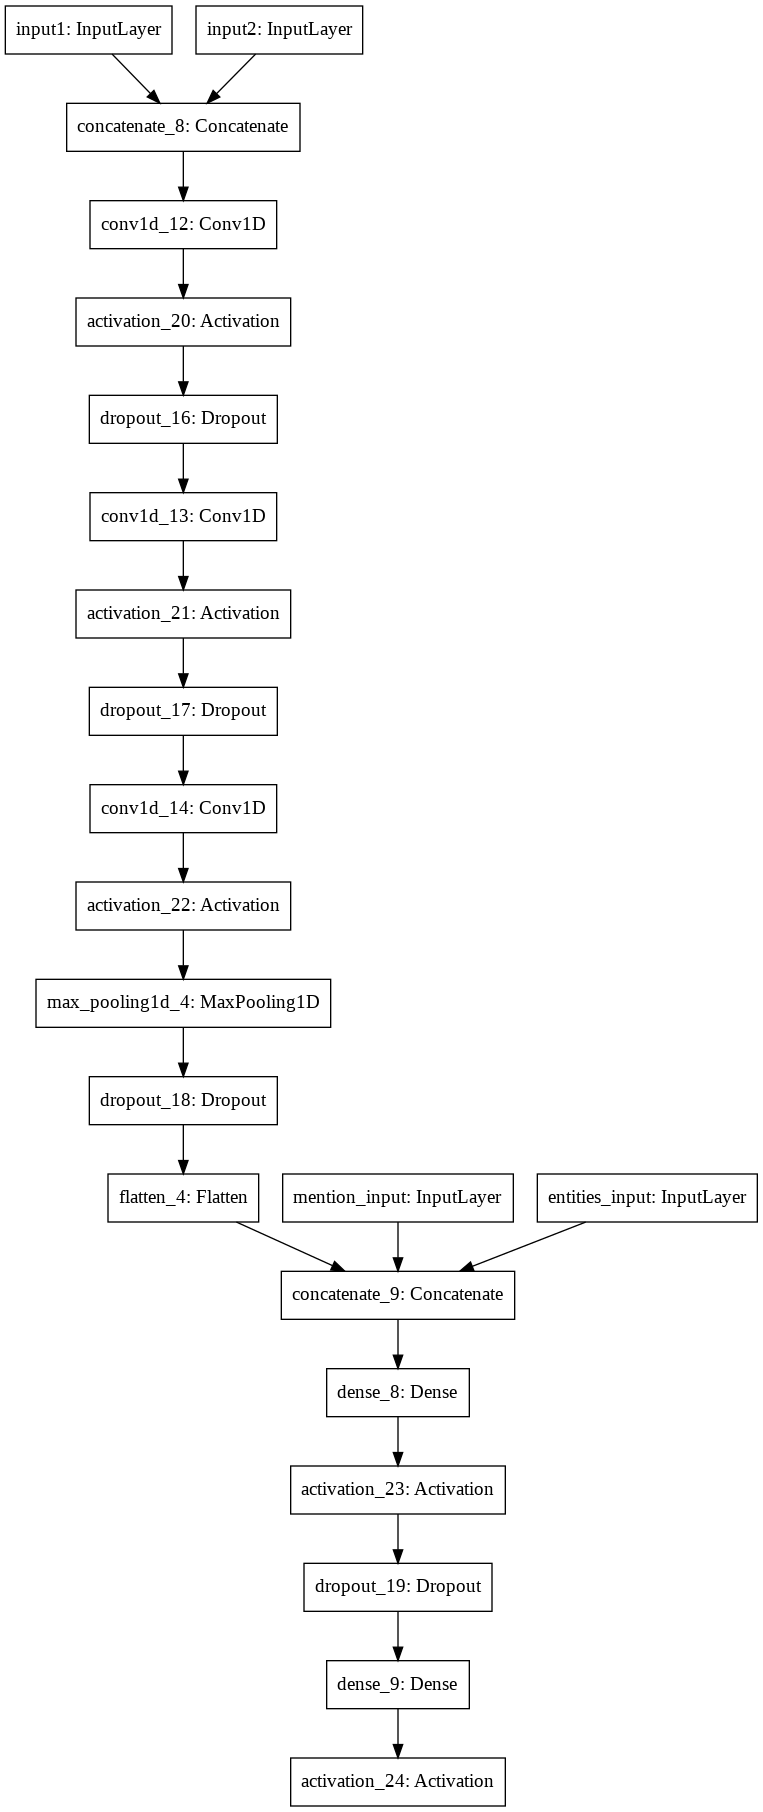

In [ ]:
plot_model(model, to_file='model.png')

In [ ]:
# initialize the number of epochs, initial learning rate and batch size
epochs = 50
lr = 1e-3
batchSize = 1

In [ ]:
opt = Adam(lr=lr, decay=lr / epochs)
loss_fn = keras.losses.categorical_crossentropy
model.compile(optimizer=opt, loss=loss_fn, metrics=["accuracy"])

## Start Training

In [ ]:
model.fit(x=[cnn_input1, cnn_input2, mention_inputs, entities_inputs], y=result, epochs=epochs, verbose=True)

Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 2.9526 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 2.0172 - accuracy: 0.7500
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 1.3166 - accuracy: 0.7500
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 1.3004 - accuracy: 0.7500
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 2.6767 - accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.2229 - accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 4.1085 - accuracy: 0.7500
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 2.2383 - accuracy: 0.7500
Epoch 9/50
1/1 [==============================] - 0s 1ms/step - loss: 2.4695 - accuracy: 0.7500
Epoch 10/50
1/1 [==============================] - 0s 2ms/step - loss: 1.0129 - accuracy: 0.7500
Epoch 11/50
1/1 [==================